In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import mode

In [2]:
# Params

exam_in = 'benchmark_radius_80_validate_20_flash'

len_list_calc_normal = 40
len_list_calc_focus = 15

thresould_quantile = 1.5
jump_after_stimulus = 50

outlier_loop = 1
alter_to = 'median' # ['mode', 'median']

In [3]:
path = '/media/marcos/Dados/Projects/Results/PupilDeep'

In [4]:
path_dataset = '{}/{}'.format(path, exam_in)
dataset_list = [x for x in os.listdir(path_dataset) if '_label.csv' in x]
print(dataset_list)

['benchmark_label.csv']


In [5]:
def make_path(path):
    try:
        os.mkdir(path)
    except FileExistsError:
        pass

In [6]:
def remove_file(file):
    try:
        os.remove(file)
    except FileNotFoundError:
        pass

In [13]:
def outlier_treatment_loop(dataset):
    Q1 = dataset['radius'].quantile(0.25)
    Q3 = dataset['radius'].quantile(0.75)
    IQR = Q3 - Q1    
    
    tq = thresould_quantile
    filter_q = (dataset['radius'] >= Q1 - tq * IQR) & (dataset['radius'] <= Q3 + tq * IQR)
    filter_q = [frame for frame, avaliable in filter_q.iteritems() if not avaliable]
    
    for frame in  filter_q:
        list_radius = np.array([])
        list_radius = dataset.loc[frame:frame+len_list_calc_normal].radius
        dataset['radius'][frame] = int(np.median(list_radius))
    
    return dataset

In [14]:
def outlier_treatment(dataset):
    for i in range(outlier_loop):
        log = 'loop outlier treatment: {}'.format(i)
        save_log(path_log, log)
        dataset = outlier_treatment_loop(dataset)
    
    return dataset

In [15]:
def get_range_flash(dataset):
    filter_flash = dataset['flash'] > 0
    frames_flash = [frame for frame, avaliable in filter_flash.iteritems() if avaliable]    
    
    init_range = [frames_flash[0]]
    end_range = []
    
    for i in range(0, len(frames_flash)-1):
        if frames_flash[i]+1 != frames_flash[i+1]:
            end_range.append(frames_flash[i])
            init_range.append(frames_flash[i+1])
            
    end_range.append(frames_flash[len(frames_flash)-1])
    
    return init_range, end_range

In [16]:
def save_log(path_log, log):
    with open(path_log, 'a') as file_out:
        file_out.write('{}\n'.format(log))    

In [20]:
def plot_graph(dataset, path_out, title):
    title_graph = '{}\lsrn: {}, lsrf: {}, tq: {}, ol: {}, at: {}, '.format(
        title, len_list_calc_normal, len_list_calc_focus, thresould_quantile, outlier_loop, alter_to)
    
    img = dataset.plot.line(x='frame', y='radius', linestyle='-', markevery=100, marker='o', title=title_graph)
    img.figure.savefig('{}/{}.pdf'.format(path_out, title))

/home/marcos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/marcos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/marcos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


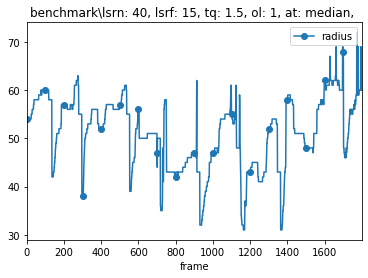

In [24]:
for file in dataset_list:
    file_in = '{}/{}'.format(path_dataset, file)
    path_out, file_out = '{}/graphs_process'.format(path_dataset), file.replace('_label.csv','')
    path_log = '{}/{}_log.txt'.format(path_out, file_out)

    make_path(path_out)
    remove_file(path_log)
    
    dataset = pd.read_csv(file_in)    
    dataset = outlier_treatment(dataset)
    
    init_range, end_range = get_range_flash(dataset)
    
    aux = 0
    for i in range(0, len(init_range)):        
        flash_dataset = dataset.loc[init_range[i]:end_range[i]]
        work_dataset = dataset.loc[aux:init_range[i]-1]
        
        frames_mod = mode(work_dataset['radius'])[0][0]
        frames_median = work_dataset['radius'].median()
        new_radius = frames_mod if alter_to == 'mode' else frames_median
        
        for index, item in flash_dataset.iterrows():
            dataset['radius'][index] = new_radius
                
        for index, item in work_dataset.iterrows():
            len_list = len_list_calc_normal
            if index > init_range[0]:
                if index <= aux + jump_after_stimulus:
                    len_list = len_list_calc_focus
                    
            range_dataset = work_dataset.loc[index:index+len_list]
            frames_mod = mode(range_dataset['radius'])[0][0]
            frames_median = range_dataset['radius'].median()
            new_radius = frames_mod if alter_to == 'mode' else frames_median
            dataset['radius'][index] = new_radius
        
        aux = end_range[i]+1
    
#     ldataset = dataset['frame'] < 200
#     dataset = dataset[ldataset]
    plot_graph(dataset, path_out, file_out)